In this notebook we will attempt to perform customer segmentation using Online Retail dataset. We will apply CRISP-DM process in our work.

# Business Understanding

Customer segmentation is the practice of dividing customers into groups that reflect similarity among customers in each group. The goal is to better understand customer's behavior and to decide how to relate to customers in each segment in order to maximize the value of each customer to the business.

In this notebook, we will divide customers into groups/segments based on how valuable they are to the company. There are three factors that are put into considerations: recency, frequency and monetary (RFM). Recency is defined as how recent is customer's last purchase. Frequency measures how many times each customer make a purchase. Monetary is how much in terms of total amount of money that each customer have brought to the company.

The Online Retail dataset tracks records of purchases made by customers from many countries. However, UK dominates the customer base of the company (as we will see later on). So it is safe to assume that we are working on a dataset from a UK-based company. Since customer purchase behavior may differ among countries, we will only focus on the domestic market, i.e. UK.

# Data Understanding & Preparation

Let's load the dataset and have a look at it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import datetime as dt
import math

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('Online Retail.csv',sep=';')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


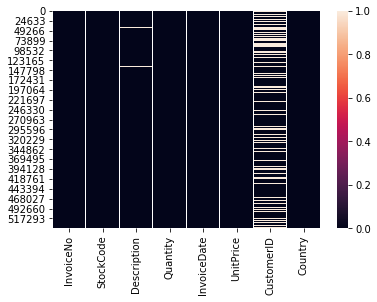

In [5]:
sns.heatmap(df.isna())

In [6]:
df[df['CustomerID'].isna()].shape

(135080, 8)

Since we are doing customer segmentation, customer identification is very important for us. Therefore, we drop all the entries without CustomerID

In [7]:
df.dropna(subset=['CustomerID'], inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null object
UnitPrice      406829 non-null float64
CustomerID     406829 non-null float64
Country        406829 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


We also drop any duplicate values

In [9]:
df.drop_duplicates(inplace=True)

Let's have a look at the descriptive statistics

In [10]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
df[df['Quantity'] < 0].shape

(8872, 8)

There are more than 8,000 rows with negative values in 'Quantity' and 'UnitPrice'. Let's have a closer look

In [12]:
df[df['Quantity'] < 0].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,01/12/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,01/12/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,01/12/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,01/12/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,01/12/2010 10:24,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,01/12/2010 10:24,0.29,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,01/12/2010 10:24,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,01/12/2010 10:24,1.65,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,01/12/2010 10:24,1.65,17548.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,01/12/2010 12:38,4.25,17897.0,United Kingdom


The most likely explanation as to why there are negative values in 'Quantity' is to indicate returned purchases. However we will assume that there is no return policy in this store for the sake of simplicity of our work. Hence, we drop all negative quantities from our dataset.

In [13]:
df = df[df['Quantity'] >= 0]

In [14]:
df.shape

(392732, 8)

Before we shift our focus on UK market, we take a look at the distribution of international sales

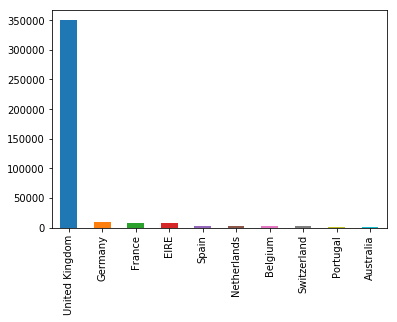

In [15]:
df['Country'].value_counts()[:10].plot(kind='bar')

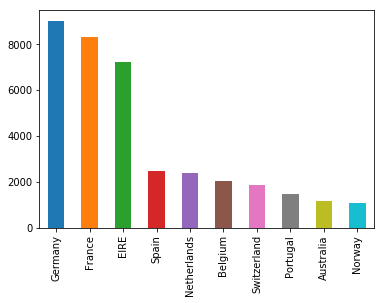

In [16]:
df['Country'].value_counts()[1:11].plot(kind='bar')

For the rest of this work, we will only focus on UK purchases.

In [17]:
df_uk = df[df['Country'] == 'United Kingdom']

In [18]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 8:26,3.39,17850.0,United Kingdom


In [19]:
#Since 'Country' only has 'United Kingdom' as its value, we can drop the column
df_uk.drop('Country', axis=1, inplace=True)

D:\PROGRAM\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [20]:
df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349227 entries, 0 to 541893
Data columns (total 7 columns):
InvoiceNo      349227 non-null object
StockCode      349227 non-null object
Description    349227 non-null object
Quantity       349227 non-null int64
InvoiceDate    349227 non-null object
UnitPrice      349227 non-null float64
CustomerID     349227 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 21.3+ MB


Next, we will check on the distribution of purchase quantites

In [21]:
df_uk.describe()

,Quantity,UnitPrice,CustomerID
count,349227.000000,349227.000000,349227.000000
mean,12.181295,2.972124,15548.333625
std,191.797470,17.990307,1594.403077
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,14191.000000
50%,4.000000,1.950000,15518.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,8142.750000,18287.000000


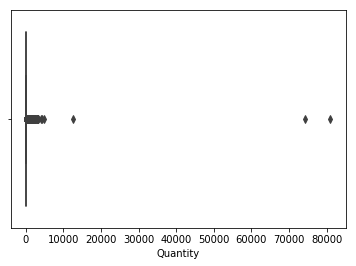

In [22]:
sns.boxplot(df_uk['Quantity'])

In [23]:
df[df['Quantity'] == df['Quantity'].max()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,PAPER CRAFT LITTLE BIRDIE,80995,09/12/2011 9:15,2.08,16446.0,United Kingdom


In [24]:
df_uk[df_uk['Quantity'] > 100].shape

(3287, 7)

We found out that most of the purchases have small quantities. There are however some purchases with absurdly large amount of quantities. We are focusing only on personal customers, and since quantities of 100 seems unlikely for personal-level customers on a single purchase, we will only work on purchases with no more than 100 quanitites.

In [25]:
# Q1 = df['Quantity'].quantile(0.25)
# Q3 = df['Quantity'].quantile(0.75)
# IQR = Q3-Q1
# IQR

In [26]:
df_uk = df_uk[df_uk['Quantity'] <= 100]

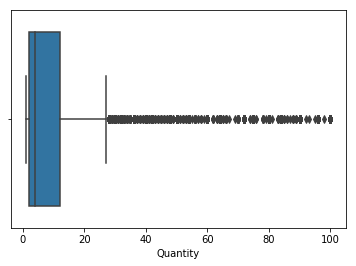

In [27]:
sns.boxplot(df_uk['Quantity'])

In [28]:
df_uk.describe()

,Quantity,UnitPrice,CustomerID
count,345940.000000,345940.000000,345940.000000
mean,9.113615,2.986628,15545.639897
std,13.129414,18.074320,1592.993885
min,1.000000,0.000000,12747.000000
25%,2.000000,1.250000,14191.000000
50%,4.000000,1.950000,15513.000000
75%,12.000000,3.750000,16931.000000
max,100.000000,8142.750000,18287.000000


https://www.datacamp.com/community/tutorials/introduction-customer-segmentation-python

https://medium.com/swlh/exploring-customers-segmentation-with-rfm-analysis-and-k-means-clustering-93aa4c79f7a7

We calculate total price on each purchase (quantity * unit price)

In [29]:
df_uk['TotalPrice'] = df_uk['Quantity'] * df_uk['UnitPrice']

In [30]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 8:26,2.55,17850.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 8:26,3.39,17850.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 8:26,2.75,17850.0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 8:26,3.39,17850.0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 8:26,3.39,17850.0,20.34


We convert the 'InvoiceDate' data type to datetime

In [31]:
df_uk['InvoiceDate'] = df_uk['InvoiceDate'].apply(pd.to_datetime)

In [32]:
df_uk['InvoiceDate'].min()

Timestamp('2010-01-12 08:26:00')

In [33]:
df_uk['InvoiceDate'].max()

Timestamp('2011-12-10 17:19:00')

We can see that this dataset tracks purchases between 12th January 2010 and 10th December 2011

We make an assumption that we perform this analysis the day after the last recorded purchase, in this case 11th December 2011

In [34]:
present = df_uk['InvoiceDate'].max() + dt.timedelta(days = 1)

After filtering the data, we can start performing RFM analysis. To do that we need RFM table.

Recency is defined as how many days since each customer's last purchase.

Frequency is defined as how many purchases made by each customer. In other words, how many times do each CustomerID appear on the dataset.

Monetary is defined as the sum of 'TotalPrice' column.

In [35]:
rfm = df_uk.groupby('CustomerID').agg({'InvoiceDate': lambda date: (present - date.max()).days,
                                   'InvoiceNo': lambda num: len(num),
                                   'TotalPrice': lambda price: price.sum()}).reset_index()

In [36]:
rfm.head()

,CustomerID,InvoiceDate,InvoiceNo,TotalPrice
0,12747.0,24,103,4196.01
1,12748.0,5,4391,30462.49
2,12749.0,24,199,4090.88
3,12820.0,46,59,942.34
4,12821.0,97,6,92.72


In [37]:
rfm.columns = ['CustomerID','recency','frequency','monetary']

In [38]:
rfm['recency'] = rfm['recency'].astype(int)

In [39]:
rfm.head()

,CustomerID,recency,frequency,monetary
0,12747.0,24,103,4196.01
1,12748.0,5,4391,30462.49
2,12749.0,24,199,4090.88
3,12820.0,46,59,942.34
4,12821.0,97,6,92.72


In [40]:
rfm.describe()

,CustomerID,recency,frequency,monetary
count,3887.000000,3887.000000,3887.000000,3887.000000
mean,15559.958323,106.604065,88.999228,1491.075612
std,1573.659717,114.787355,213.975816,3511.504925
min,12747.000000,1.000000,1.000000,2.900000
25%,14208.500000,23.000000,17.000000,285.815000
50%,15565.000000,62.000000,40.000000,621.660000
75%,16909.500000,163.000000,98.000000,1498.385000
max,18287.000000,698.000000,7671.000000,71615.640000


D:\PROGRAM\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


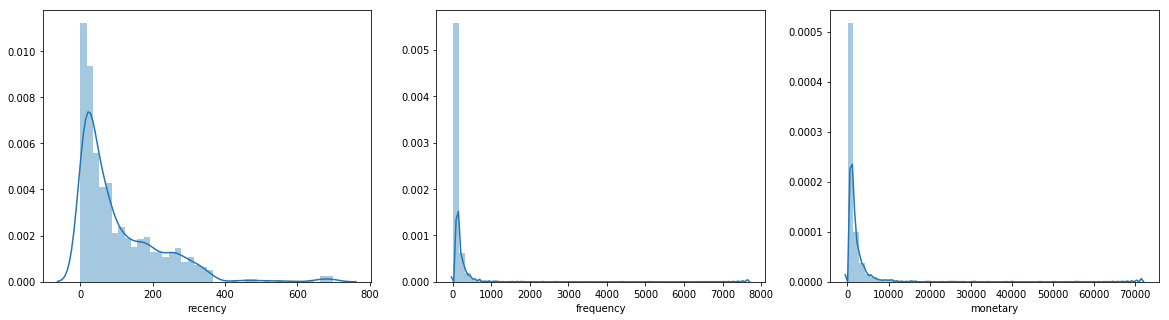

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
for i, feature in enumerate(list(rfm.columns[1:])):
    sns.distplot(rfm[feature], ax=axes[i])

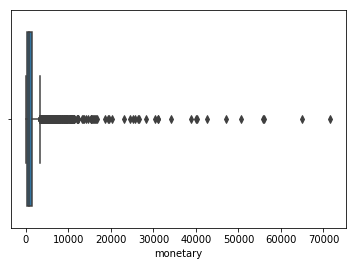

In [42]:
sns.boxplot(rfm['monetary'])

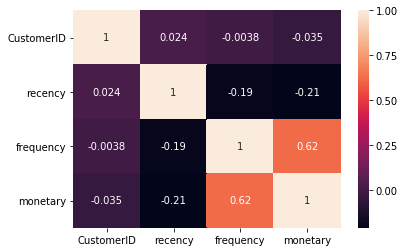

In [43]:
sns.heatmap(rfm.corr(),annot=True)

There are a couple of things we need to address before we apply clustering algorithms. First, we need to perform feature scaling. In this case we will use StandardScaler. Second, there is a huge range of values in frequency and monetary variables. Because of that, we need to perform logarithmic transformation for all variables. These steps are necessary to improve the performance of the clustering algorithm.

In [71]:
rfm_t = rfm.copy()

In [72]:
rfm_t.describe()

,CustomerID,recency,frequency,monetary
count,3887.000000,3887.000000,3887.000000,3887.000000
mean,15559.958323,106.604065,88.999228,1491.075612
std,1573.659717,114.787355,213.975816,3511.504925
min,12747.000000,1.000000,1.000000,2.900000
25%,14208.500000,23.000000,17.000000,285.815000
50%,15565.000000,62.000000,40.000000,621.660000
75%,16909.500000,163.000000,98.000000,1498.385000
max,18287.000000,698.000000,7671.000000,71615.640000


In [73]:
rfm_t['recency'] = rfm_t['recency'].apply(math.log)
rfm_t['frequency'] = rfm_t['frequency'].apply(math.log)
rfm_t['monetary'] = rfm_t['monetary'].apply(math.log)

X_subset = rfm_t[['recency','frequency','monetary']]
scaler = StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe()

,recency,frequency,monetary
count,3.887000e+03,3.887000e+03,3.887000e+03
mean,4.125562e-16,-2.724859e-17,-2.262147e-17
std,1.000129e+00,1.000129e+00,1.000129e+00
min,-3.022401e+00,-2.764301e+00,-4.435079e+00
25%,-6.556560e-01,-6.239886e-01,-6.775174e-01
50%,9.285727e-02,2.241268e-02,-4.148146e-02
75%,8.224816e-01,6.993502e-01,6.786181e-01
max,1.920349e+00,3.993230e+00,3.843805e+00


D:\PROGRAM\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


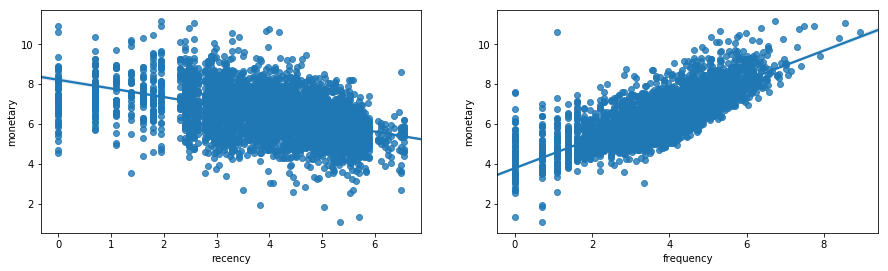

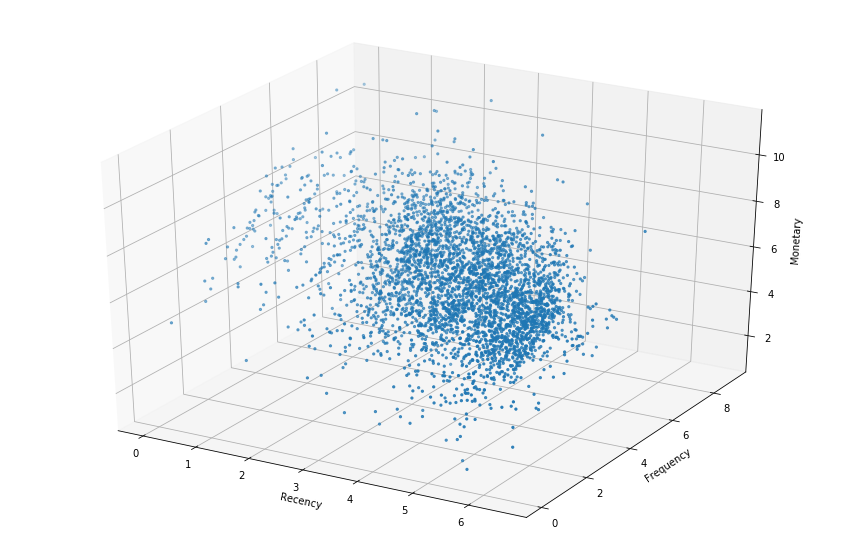

In [74]:
fig = plt.figure(figsize=(15,9))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='monetary', data=rfm_t)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='monetary', data=rfm_t)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs = rfm_t['recency']
ys = rfm_t['frequency']
zs = rfm_t['monetary']
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

From the visualization above we can see that there seems to be a correlation between recency and monetary. The correlation however is not as strong as the correlation between frequency and monetary.

# Modeling and Evaluation

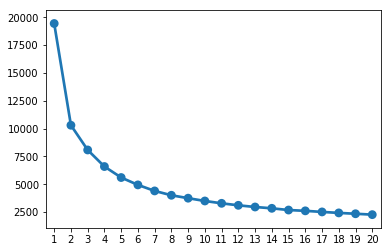

In [48]:
SSE = []
for k in range(0,20):
    kmeans = KMeans(n_clusters=k+1, init='k-means++').fit(rfm_t[['recency','frequency','monetary']])
    SSE.append(kmeans.inertia_)
    
sns.pointplot(x=list(range(1,21)), y=SSE)
plt.show()

As the figure show, the decrement in inertia after k=5 is insignificant. Therefore, we will group the customers into 5 segments.

In [75]:
k5means = KMeans(n_clusters=5, init='k-means++').fit(rfm_t[['recency','frequency','monetary']])

In [97]:
labels = k5means.labels_
centers = k5means.cluster_centers_

We assign each customers to their respective segments and find the percentage of each segments

In [106]:
lab_df = pd.DataFrame(labels)
lab_df.columns = ['segment']
rfm_t['segment'] = lab_df['segment']
rfm_t.head()

,CustomerID,recency,frequency,monetary,segment
0,12747.0,3.178054,4.634729,8.341889,3
1,12748.0,1.609438,8.387312,10.324251,3
2,12749.0,3.178054,5.293305,8.316515,3
3,12820.0,3.828641,4.077537,6.848366,2
4,12821.0,4.574711,1.791759,4.529584,4


In [114]:
print('Percentage of customers in Segment 0: ', len(rfm_t[rfm_t['segment'] == 0]) / len(rfm_t))
print('Percentage of customers in Segment 1: ', len(rfm_t[rfm_t['segment'] == 1]) / len(rfm_t))
print('Percentage of customers in Segment 2: ', len(rfm_t[rfm_t['segment'] == 2]) / len(rfm_t))
print('Percentage of customers in Segment 3: ', len(rfm_t[rfm_t['segment'] == 3]) / len(rfm_t))
print('Percentage of customers in Segment 4: ', len(rfm_t[rfm_t['segment'] == 4]) / len(rfm_t))

Percentage of customers in Segment 0:  0.17159763313609466
Percentage of customers in Segment 1:  0.2883972215075894
Percentage of customers in Segment 2:  0.23462824800617443
Percentage of customers in Segment 3:  0.13763828145099047
Percentage of customers in Segment 4:  0.167738615899151


In [98]:
cluster_centers = pd.DataFrame(centers)

In [99]:
cluster_centers.columns = ['recency','frequency','monetary']

In [105]:
cluster_centers.head()

,recency,frequency,monetary
0,2.768188,3.401284,6.207687
1,5.051774,3.337750,6.005342
2,4.019689,4.619673,7.336923
3,2.195889,5.397540,8.245496
4,4.929172,1.705909,4.945658


# Segmentation Results

We have divided the customers into 5 segments (0 to 4). By looking at the cluster centers, we can analyze the behavior of each segments. Here are the characteristics of each customer segments, sorted from the most valuable segments to the least:

Segment 3 is the most valuable in all factors (recency, frequency, and monetary). These customers brings the most value to the company.

Segment 2 has significantly less value in recency but is not to far off in terms of frequency and monetary compared to Segment 3.

Segment 0 has less value in frequency and monetary compared to Segment 2, but significantly ahead in terms of recency.

Segment 1 has the worst recency value, but still better than Segment 4 in terms of frequency and monetary.

Segment 4 is the least valuable customers for the company since it has by far the worst value in frequency and monetary.

To finish off this work, we plot the segmentation

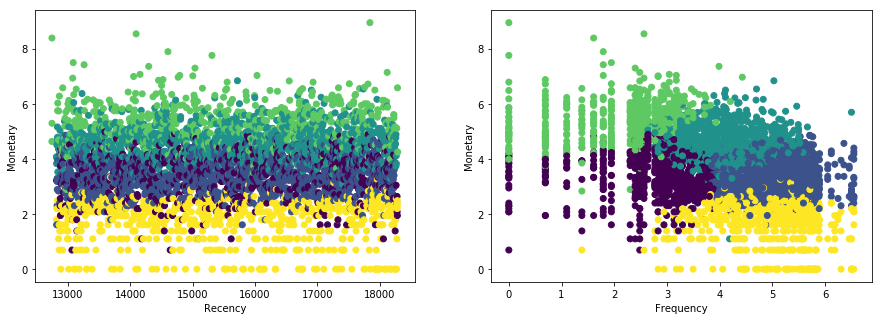

In [107]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
plt.scatter(x = rfm_t.values[:,0], y = rfm_t.values[:,2], c=k5means.labels_.astype(float))
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax = fig.add_subplot(122)
plt.scatter(x = rfm_t.values[:,1], y = rfm_t.values[:,2], c=k5means.labels_.astype(float))
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')

plt.show()